## Load data

Load in the data and handle multiple rows for the same day in speeches.csv

In [1]:
import pandas as pd

# Load exchange rates file

fx = pd.read_csv("./data/fx.csv", skiprows=6, header=None, usecols=[0,1], 
                 na_values=['-'])  #missing exchange rates are marked '-'
fx.columns = ["date", "exchange_rate"]

fx.info()
fx

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5851 entries, 0 to 5850
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           5851 non-null   object 
 1   exchange_rate  5789 non-null   float64
dtypes: float64(1), object(1)
memory usage: 91.5+ KB


,date,exchange_rate
0,2021-08-12,1.1739
1,2021-08-11,1.1718
2,2021-08-10,1.1722
3,2021-08-09,1.1761
4,2021-08-06,1.1807
...,...,...
5846,1999-01-08,1.1659
5847,1999-01-07,1.1632
5848,1999-01-06,1.1743
5849,1999-01-05,1.1790


In [2]:
# Load speeches file

speeches = pd.read_csv("./data/speeches.csv", sep = '|', encoding='utf-8')
speeches = speeches[['date', 'contents']]
#speeches = pd.read_csv("./data/speeches.csv", sep='|', encoding='utf-8', usecols=['date', 'contents'])

speeches.dropna(inplace=True)
#speeches.dropna(inplace=True, subset=['contents'])

# Group 'contents' by 'date', then join all contents by date
# We need to also reset index
speeches = speeches.groupby('date')['contents'].apply(lambda x: " ".join(x)).reset_index()
#speeches = speeches.groupby('date')['contents'].apply(lambda x: " ".join(x.astype(str))).reset_index()
speeches.info()
speeches


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1894 non-null   object
 1   contents  1894 non-null   object
dtypes: object(2)
memory usage: 29.7+ KB


,date,contents
0,1997-02-07,Conference organised by the Hungarian Bankin...
1,1997-03-10,Securing the benefits of EMU Address by Al...
2,1997-04-22,Convergence and the role of the European Cen...
3,1997-04-30,The operation of monetary policy in stage th...
4,1997-05-13,The European Central Bank: independent and a...
...,...,...
1889,2021-06-29,SPEECH Financing a green and digital recov...
1890,2021-07-03,SPEECH Escaping low inflation? Speech by...
1891,2021-07-08,OPENING REMARKS PRESS CONFERENCE Christi...
1892,2021-07-11,SPEECH Climate Change and Central Banks: A...


## Merge data

In [4]:
# Merge fx and speeches data into one dataset

# Combine fx and speeches into a new dataframe
df = pd.merge(fx, speeches, how='left')
#df = pd.merge(fx, speeches, on='date', how='left')

# Convert 'date' to be of date type
df['date'] = pd.to_datetime(df['date'])
df['exchange_rate'] = pd.to_numeric(df['exchange_rate'])

# Set index to 'date'
df.set_index('date', inplace= True)
df.info()
#df.index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5851 entries, 2021-08-12 to 1999-01-04
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   exchange_rate  5789 non-null   float64
 1   contents       1734 non-null   object 
dtypes: float64(1), object(1)
memory usage: 137.1+ KB


## Remove entries with obvious outliers or mistakes

We first see if there is any obvious outliers or mistakes by plotting the data

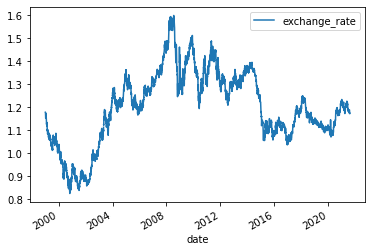

In [5]:
df.plot()

In [6]:
df.describe()

,exchange_rate
count,5789.000000
mean,1.199705
std,0.160200
min,0.825200
25%,1.101100
50%,1.202300
75%,1.318000
max,1.599000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5851 entries, 2021-08-12 to 1999-01-04
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   exchange_rate  5789 non-null   float64
 1   contents       1734 non-null   object 
dtypes: float64(1), object(1)
memory usage: 137.1+ KB


The data does not seem to have obvious outliers or mistakes. 

## Handle missing observations for the exchange rates

In [8]:
# Check if there is missing data
df.isna().sum()

exchange_rate      62
contents         4117
dtype: int64

In [9]:
# Fill in the exchange rate with the latest information available
df.exchange_rate.fillna(method='bfill', inplace=True)  # handle missing exchange rates

In [10]:
# Check again if there's more missing data
df.isna().sum()

exchange_rate       0
contents         4117
dtype: int64

In [11]:
df

,exchange_rate,contents
date,,
2021-08-12,1.1739,NaN
2021-08-11,1.1718,NaN
2021-08-10,1.1722,NaN
2021-08-09,1.1761,NaN
2021-08-06,1.1807,NaN
...,...,...
1999-01-08,1.1659,NaN
1999-01-07,1.1632,NaN
1999-01-06,1.1743,NaN


## Calculate exchange rate return

In [12]:
# Get the exchange rate return ((current_rate-previous_rate)/(previous_rate))
# 'df.exchange_rate.pct_change(-1)' computes % change from following/next row's exchange rate
# Since dataframe is sorted by most recent dates, this is what we want

df['return'] = df.exchange_rate.pct_change(-1)
df

,exchange_rate,contents,return
date,,,
2021-08-12,1.1739,NaN,0.001792
2021-08-11,1.1718,NaN,-0.000341
2021-08-10,1.1722,NaN,-0.003316
2021-08-09,1.1761,NaN,-0.003896
2021-08-06,1.1807,NaN,-0.003629
...,...,...,...
1999-01-08,1.1659,NaN,0.002321
1999-01-07,1.1632,NaN,-0.009452
1999-01-06,1.1743,NaN,-0.003986


## Extend the original dataset with “good_news” and “bad_news” variables

In [13]:
# Extend the dataframe with the variables "good_news" and "bad_news"
df['good_news'] = (df['return'] > 0.5/100).astype(int)
df['bad_news'] = (df['return'] < -0.5/100).astype(int)
df

,exchange_rate,contents,return,good_news,bad_news
date,,,,,
2021-08-12,1.1739,NaN,0.001792,0,0
2021-08-11,1.1718,NaN,-0.000341,0,0
2021-08-10,1.1722,NaN,-0.003316,0,0
2021-08-09,1.1761,NaN,-0.003896,0,0
2021-08-06,1.1807,NaN,-0.003629,0,0
...,...,...,...,...,...
1999-01-08,1.1659,NaN,0.002321,0,0
1999-01-07,1.1632,NaN,-0.009452,0,1
1999-01-06,1.1743,NaN,-0.003986,0,0


## Remove the entries for which contents column has NA values

In [14]:
# Remove rows with NAs
df.dropna(inplace=True)
df.head()

,exchange_rate,contents,return,good_news,bad_news
date,,,,,
2021-07-14,1.1812,SPEECH A new strategy for a changing world...,-0.002702,0,0
2021-07-08,1.1838,OPENING REMARKS PRESS CONFERENCE Christi...,0.000592,0,0
2021-06-29,1.1888,SPEECH Financing a green and digital recov...,-0.001847,0,0
2021-06-28,1.1910,SPEECH Euro area banks in the recovery S...,-0.003347,0,0
2021-06-21,1.1891,SPEECH Hearing of the Committee on Economi...,-0.000588,0,0


In [ ]:
df.info()

## Associate words with "good_news" and "bad_news"

In [ ]:
#df.contents[df.good_news==1]

In [ ]:
#df.contents[df.bad_news==1]

In [15]:
# Get the contents related to "good_news" and "bad_news"
# Concatenate all "good news" contents into one long string 'good_news_content'
# Concatenate all "bad news" contents into one long string 'bad_news_content'
good_news_contents = df.contents[df.good_news==1].str.cat(sep=' ')
bad_news_contents = df.contents[df.bad_news==1].str.cat(sep=' ')

In [16]:
# You may download the list of stop words from this link -- https://countwordsfree.com/stopwords
# You can also use any other sources
# Load the list of stop words into a set
stop_words = set(pd.read_csv("./data/stop_words_english.txt", header=None).iloc[:,0].tolist())
stop_words

{"'ll",
 "'ve",
 'I',
 'a',
 "a's",
 'able',
 'about',
 'above',
 'abroad',
 'abst',
 'accordance',
 'according',
 'accordingly',
 'across',
 'act',
 'actually',
 'added',
 'adj',
 'adopted',
 'affected',
 'affecting',
 'affects',
 'after',
 'afterwards',
 'again',
 'against',
 'ago',
 'ah',
 'ahead',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'alongside',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amid',
 'amidst',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'announce',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anymore',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'apparently',
 'appear',
 'appreciate',
 'appropriate',
 'approximately',
 'are',
 'aren',
 "aren't",
 'arent',
 'arise',
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'auth',
 'available',
 'away',
 'awfully',
 'b',
 'back',
 'backward',
 'backwards',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 '

In [ ]:
#pd.read_csv("./data/stop_words_english.txt", header=None)
#pd.read_csv("./data/stop_words_english.txt", header=None).iloc[:,0]
#pd.read_csv("./data/stop_words_english.txt", header=None).iloc[:,0].tolist()

In [ ]:
# Below is a basic word count function as a starting point

#def word_count(str):
#    counts = dict()
#    words = str.split()
#    for word in words:
#        if word in counts:
#            counts[word] += 1
#        else:
#            counts[word] = 1
#    return counts


In [17]:
# The function below helps us to get the most common words (excluding stop_words) related to good_news and bad_news. 
# Please read the comments to understand how it works:

import string

def get_word_freq(contents, stop_words, num_words):
    
    freq = dict()
    
    for word in contents.split():
        
        word = word.strip(string.punctuation+'–')  #remove all punctuations
        word = word.lower()  #convert to lower case
        
        if (word not in stop_words) and len(word):
            if word in freq:
                freq[word] += 1
            else:
                freq[word] = 1
    
    # Goes through the all items in the dictionary and sort by value (item[1]) in reverse order
    # Converts the resulting list to a dictionary
    # Syntax for sorted: sorted(iterable, key, reverse)

    freq = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True)) 
    #freq = dict(sorted(freq.items(), key = lambda item: -item[1]))  #alternative that sorts on negated value
    
    return list(freq.items())[:num_words]
    #return list(freq.keys())[:num_words]  #to return just the keys


In [18]:
# Use the function above to get the 20 most common words associated with `good_news` and `bad_news`
good_indicators = get_word_freq(good_news_contents, stop_words, num_words = 20)
bad_indicators = get_word_freq(bad_news_contents, stop_words, num_words = 20)

In [19]:
good_indicators

[('euro', 6815),
 ('financial', 6437),
 ('policy', 5738),
 ('monetary', 5521),
 ('area', 4698),
 ('economic', 3594),
 ('market', 3412),
 ('central', 3303),
 ('stability', 3055),
 ('ecb', 2902),
 ('banks', 2869),
 ('inflation', 2840),
 ('european', 2797),
 ('der', 2716),
 ('die', 2704),
 ('price', 2572),
 ('growth', 2506),
 ('countries', 2443),
 ('la', 2437),
 ('markets', 2365)]

In [20]:
bad_indicators

[('euro', 7433),
 ('financial', 6786),
 ('policy', 5783),
 ('monetary', 5589),
 ('area', 5306),
 ('market', 3767),
 ('central', 3688),
 ('economic', 3562),
 ('banks', 3525),
 ('stability', 3210),
 ('european', 3002),
 ('ecb', 2834),
 ('growth', 2783),
 ('price', 2706),
 ('la', 2587),
 ('markets', 2570),
 ('bank', 2570),
 ('inflation', 2539),
 ('countries', 2440),
 ('risk', 2134)]

Note that many terms appear in both, and the results are not the same as R. It may because the `word_tokenizer()` in R may not work the same way as `split()` with `strip()`.

In [21]:
# Alternative -- Using Counter from collections module

from collections import Counter
import string

def get_word_freq2(contents, stop_words, num_words):
    
    wordlist = list()
    
    for word in contents.split():
        
        word = word.strip(string.punctuation+'–')  #remove all punctuations
        word = word.lower()  #convert to lower case
        
        if (word not in stop_words) and len(word):
            wordlist.append(word)
        
    freq = Counter(wordlist)
    
    return freq.most_common(num_words)

print('good_indicators')
print(get_word_freq2(good_news_contents, stop_words, num_words = 20))
print('\nbad_indicators')
print(get_word_freq2(bad_news_contents, stop_words, num_words = 20))


good_indicators
[('euro', 6815), ('financial', 6437), ('policy', 5738), ('monetary', 5521), ('area', 4698), ('economic', 3594), ('market', 3412), ('central', 3303), ('stability', 3055), ('ecb', 2902), ('banks', 2869), ('inflation', 2840), ('european', 2797), ('der', 2716), ('die', 2704), ('price', 2572), ('growth', 2506), ('countries', 2443), ('la', 2437), ('markets', 2365)]

bad_indicators
[('euro', 7433), ('financial', 6786), ('policy', 5783), ('monetary', 5589), ('area', 5306), ('market', 3767), ('central', 3688), ('economic', 3562), ('banks', 3525), ('stability', 3210), ('european', 3002), ('ecb', 2834), ('growth', 2783), ('price', 2706), ('la', 2587), ('markets', 2570), ('bank', 2570), ('inflation', 2539), ('countries', 2440), ('risk', 2134)]


In [22]:
# Alternative + Additional -- Using Counter from collections module and applying lemmatization

from collections import Counter
import string

import nltk
from nltk.stem import WordNetLemmatizer 
#nltk.download('wordnet') #run this if need to download package wordnet

def get_word_freq2(contents, stop_words, num_words):
    
    wordlist = list()
    
    # Initialise the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    for word in contents.split():
        
        word = word.strip(string.punctuation+'–')  #remove all punctuations
        word = word.lower()  #convert to lower case
        word = lemmatizer.lemmatize(word)
        
        if (word not in stop_words) and len(word):
            wordlist.append(word)

    freq = Counter(wordlist)
    
    return freq.most_common(num_words)

print('good_indicators')
print(get_word_freq2(good_news_contents, stop_words, num_words = 20))
print('\nbad_indicators')
print(get_word_freq2(bad_news_contents, stop_words, num_words = 20))


good_indicators
[('euro', 6903), ('policy', 6825), ('financial', 6437), ('market', 5777), ('monetary', 5521), ('bank', 5126), ('area', 5005), ('ha', 4923), ('price', 3635), ('economic', 3594), ('rate', 3590), ('central', 3303), ('la', 3090), ('stability', 3055), ('ecb', 2902), ('risk', 2889), ('inflation', 2842), ('european', 2835), ('country', 2827), ('der', 2716)]

bad_indicators
[('euro', 7468), ('financial', 6786), ('policy', 6754), ('market', 6337), ('bank', 6095), ('area', 5655), ('monetary', 5589), ('ha', 5286), ('rate', 4013), ('price', 3891), ('central', 3688), ('economic', 3562), ('risk', 3448), ('stability', 3210), ('european', 3038), ('country', 2896), ('la', 2853), ('ecb', 2834), ('growth', 2783), ('economy', 2588)]
